In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import matplotlib

## 1. Поиск средней и медианой прибыли 
### 1.1 Прогнозирование возможного спроса

In [3]:
std_n = 500
mean_n = 2500

"""
Так как среднее значение и стандартное отклонение дано для нормального распределения, 
надо найти те же посчитать те же значения для логонормального распределния
""" 


std_log = np.sqrt(np.log((std_n ** 2) /(mean_n ** 2) + 1))
mean_log = np.log(mean_n) - (std_log ** 2) / 2
    
demand = np.random.lognormal(mean_log, std_log, size=100000)
demand = np.round(demand) # округляем значение, так как спрос на упаковку печенья дискретен(мы не можем продавать нецелую пачку)


cookies_demand = np.random.lognormal(mean_n, std_n, 100000)

### 1.2 Графическое представление потенциальных прибылей

In [7]:
np.random.seed(42)
n = 70000
potential_production = np.arange(mean_n - 3 * std_n, mean_n + 3 * std_n, 1) #Рассмотрим наиболее возможные
res = {}


for prod in potential_production:
    sale = np.random.lognormal(mean_log, std_log, size=n)
    cash = np.array([min(i, prod) * 50 + max(prod - i, 0) * 15 - prod * 30 for i in sale])
    
    delta = sale - prod
    profit = np.where(delta >= 0, delta *(50 - 30), 0)
    loss = np.where(delta >= 0, 0, delta * (15 - 30))
    cash_mean = np.mean(cash)
    profit_mean = np.mean(profit)
    loss_mean = np.mean(loss)
    cash_25, cash_75, cash_median = np.quantile(cash, [0.25, 0.75, 0.5])
    res[prod] = {'cash_mean': cash_mean, 'cash_median':cash_median,
                 'cash_25':cash_25, 'cash_75':cash_75, 'profit_mean':profit_mean, 'loss_mean':loss_mean, 'cash':cash,}

df = pd.DataFrame(res).T.drop(columns = ['cash'])
display(df.head(3))
df_cash = pd.DataFrame(np.array([sub_dict['cash'] for sub_dict in res.values()]).T, columns=res.keys())
display(df_cash.head(3))

,cash_mean,cash_median,cash_25,cash_75,profit_mean,loss_mean
1000,20000.0,20000.0,20000.0,20000.0,30015.725037,0.0
1001,20020.0,20020.0,20020.0,20020.0,30003.411828,0.0
1002,20040.0,20040.0,20040.0,20040.0,29931.165199,0.0


,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,20000.0,20020.0,20040.0,20060.0,20080.0,20100.0,20120.0,20140.0,20160.0,20180.0,...,43264.273457,25054.265432,26080.970771,1675.126854,29641.380031,14074.098643,34359.701816,33100.109589,16703.031995,22784.130215
1,20000.0,20020.0,20040.0,20060.0,20080.0,20100.0,20120.0,20140.0,20160.0,20180.0,...,22198.074747,-11403.773938,39071.964100,20857.292482,18749.524100,16252.833959,20975.948831,69815.048762,32327.408075,57966.472836
2,20000.0,20020.0,20040.0,20060.0,20080.0,20100.0,20120.0,20140.0,20160.0,20180.0,...,39710.508556,21151.999162,29852.722745,41475.138765,24161.052825,65902.691086,8575.633708,4031.653219,52049.922738,39432.182189


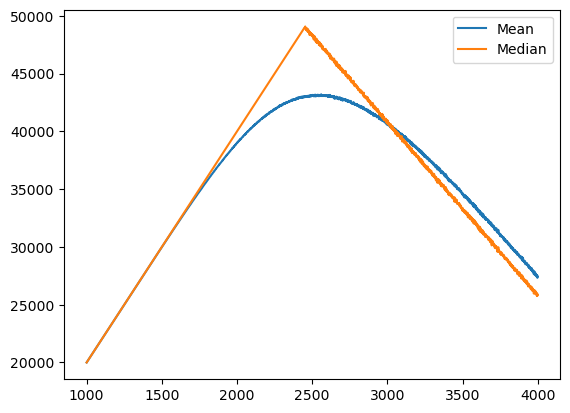

In [11]:
plt.plot(df.index, df.cash_mean, label='Mean')
plt.plot(df.index, df.cash_median, label='Median')
plt.legend()
plt.show()

## 2.1 Поиск оптимального выпуска
Оптимальный выпуск - это выпуск, при котором мы будем получать наибольшую прибыль. Так как, производя печенье, мы не знаем, какой будет спрос, то оптимальным решением будет, тот выпуск, при котором прибыль будет независимо от спроса в среднем выше, чем при другом выпуске. При таком выпуске в долгосрочной перспективе наша прибыль будет маскимальна.

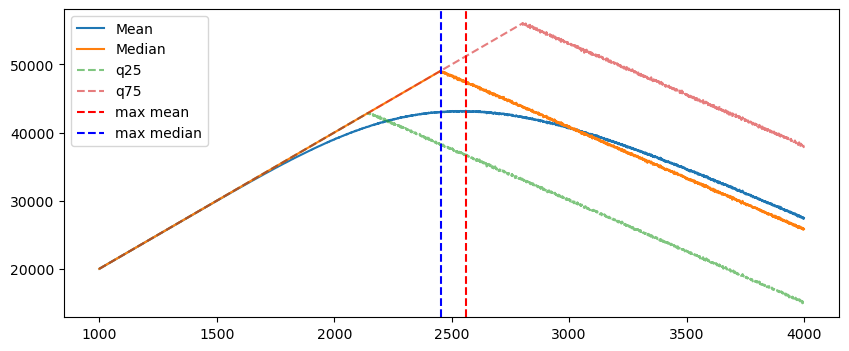

In [17]:
plt.subplots(figsize=[10,4])

plt.plot(df.index, df.cash_mean, label='Mean')
plt.plot(df.index, df.cash_median, label='Median')
plt.plot(df.index, df.cash_25, label='q25', linestyle='--', alpha=0.6)
plt.plot(df.index, df.cash_75, label='q75', linestyle='--', alpha=0.6)

plt.axvline(x=df.cash_mean.astype('float').idxmax(), linestyle='--', color='red', label='max mean') 
plt.axvline(x=df.cash_median.astype('float').idxmax(), linestyle='--', color='blue', label='max median') 

plt.legend()
plt.show()

In [19]:
# Возьмем среднее значение за оптимальный выпуск(можно взять и медиану)
opt_prod = df.cash_mean.astype('float').idxmax()
opt_prod

2560

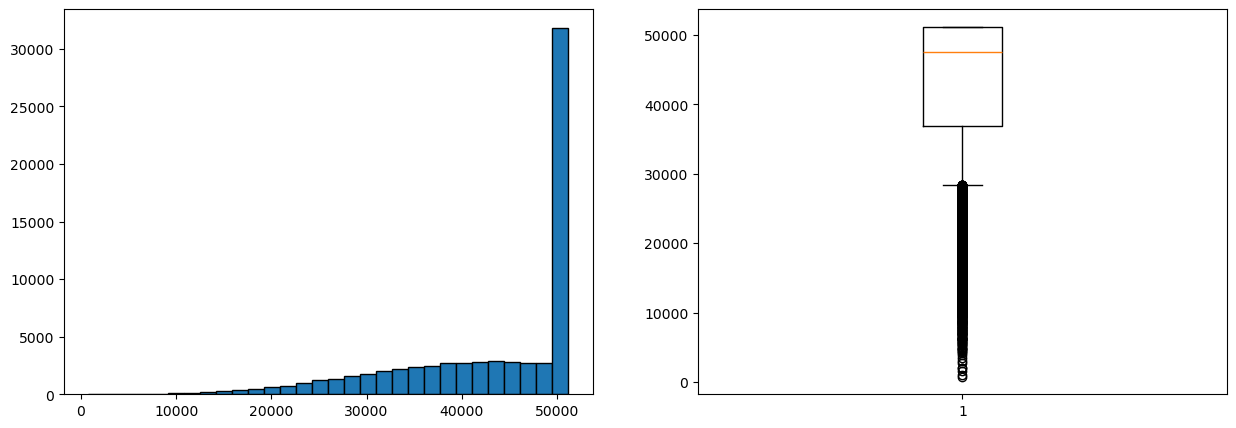

In [29]:
fig, ax = plt.subplots(1,2, figsize=[15,5])
ax[0].hist(df_cash[opt_prod], bins=30,edgecolor='black')
ax[1].boxplot(df_cash[opt_prod], whis=[10, 90])
plt.show()

### 2.2 График потенциальных выпусков и их средних прибылей
График потенциальных представляет собой перевенутую параболу. Это демонстрирует, что при выбранным нами оптимальном выпуске средняя прибыль максимально и при других выпусках, не вошедших в рассматриваемый интервал, прибыль не будет выше 

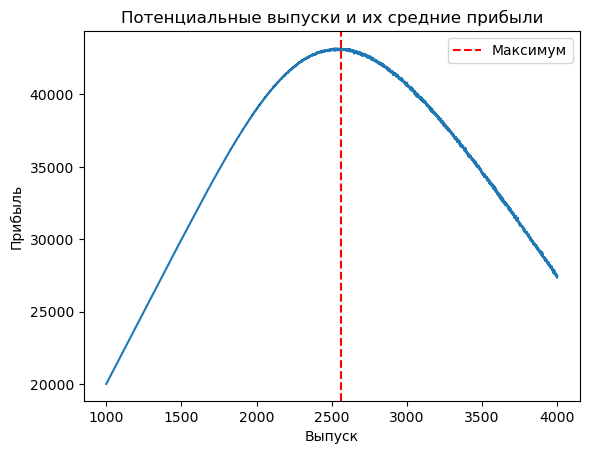

In [33]:
def rev_plot(potential_production, revenues):
    plt.plot(potential_production, revenues)
    plt.xlabel('Выпуск')
    plt.ylabel('Прибыль')
    plt.title('Потенциальные выпуски и их средние прибыли')

    plt.axvline(opt_prod,color='r', linestyle='--', label='Максимум')
    plt.legend()
    plt.show()

rev_plot(potential_production, df.cash_mean)

## 3.1 Потенциальные убытки при недостатке и избытка выпуска

C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\andre\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


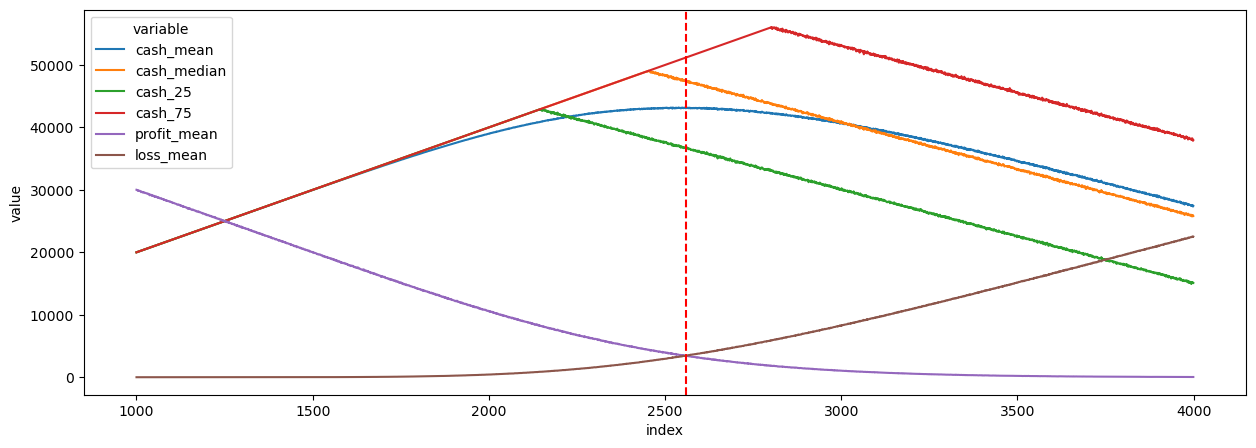

In [45]:
dfm = df.reset_index().melt(id_vars='index')

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=dfm, x='index', y='value', hue='variable', legend=True, ax=ax)
ax.axvline(x=df.cash_mean.astype('float').idxmax(), linestyle='--', color='red') 
plt.show()

In [48]:
excess = df.loc[opt_prod, 'profit_mean']
losses = df.loc[opt_prod, 'loss_mean']
excess, losses # средние потери при избытке и недостатке

(3472.671092283966, 3422.875337069068)